In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
from dsn.util.dsn_util import get_system_from_template
import seaborn as sns
import pandas as pd
import warnings
import scipy
import time
warnings.filterwarnings("ignore")
import os

os.chdir('../../')

In [30]:
sysname = 'V1Circuit'
behavior_type = "ISN_coeff"
param_dict = {'behavior_type':behavior_type,
              'silenced':'S'}
system = get_system_from_template(sysname, param_dict)

{'type': 'ISN_coeff', 'mean': 0.0, 'std': 0.25, 'c_vals': array([1.]), 's_vals': array([5]), 'r_vals': array([0.]), 'silenced': 'V'}
ISN_coeff


In [31]:
np.random.seed(0)
M = 2000

min_W = 0.0
max_W = 10.0
# column 2
W_XE = np.random.uniform(0.0, max_W, (M,))

W_EP = np.random.uniform(0.0, max_W, (M,))
W_PP = np.random.uniform(0.0, max_W, (M,))
W_VP = np.random.uniform(0.0, max_W, (M,))
W_ES = np.random.uniform(0.0, 10.0, (M,))
W_PS = np.random.uniform(0.0, 10.0, (M,))
W_VS = np.random.uniform(0.0, max_W, (M,))
W_SV = np.random.uniform(0.0, max_W, (M,))

_Z = np.stack((W_XE, W_EP, W_PP, W_VP, W_ES, W_PS, W_VS, W_SV), axis=1)
_Z = np.expand_dims(_Z, 0)


In [32]:

num_params = system.D;
Z = tf.placeholder(dtype=tf.float64, shape=(1, None, num_params));

sess = tf.Session()
T_x = system.simulation_suff_stats(Z)
r_t = system.simulate(Z)

In [33]:

_T_x, _r_t = sess.run([T_x, r_t], {Z:_Z});


In [34]:
r_ss_E = _r_t[-1,0,:,0,0]
r_ss_P = _r_t[-1,0,:,1,0]
r_ss_S = _r_t[-1,0,:,2,0]
r_ss_V = _r_t[-1,0,:,3,0]

r_ss = _r_t[-1, 0, :, :, 0]

u_E = np.sqrt(_r_t[-1,0,:,0,0])
betas = 1 - 2*u_E*system.fixed_params['W_EE']

plot_th = 1e2
stable_inds = np.logical_and(np.logical_and(r_ss_E < plot_th, r_ss_P < plot_th), np.logical_and(r_ss_S < plot_th, r_ss_V < plot_th))
E_on = r_ss_E > 1e-2
plot_inds = np.logical_and(E_on, stable_inds)

In [35]:
print(betas)
print(np.sum(plot_inds))

[0.99999156 0.99999156 0.99999156 ... 0.99999156 0.29451829 0.99999156]
357


In [36]:
t = np.linspace(0.0, system.dt*(system.T-1), system.T)
black = 'k'
red =  [0.8, 0.0, 0.0]
blue = [0.0, 0.0, 0.8]
green = [0.0, 0.8, 0.0]

In [10]:
plot_traces = False
if (plot_traces):
    r_ss_E = np.zeros((M,))
    for i in range(M):
        if (plot_inds[i]):
            plt.figure()
            plt.plot(t, _r_ts[0][:,0,i,0,0], '-', c=black)
            plt.plot(t, _r_ts[0][:,0,i,1,0], '--', c=blue)
            plt.plot(t, _r_ts[0][:,0,i,2,0],'-',  c=red)
            plt.plot(t, _r_ts[0][:,0,i,3,0], '--', c=green)
            plt.legend(['E', 'P', 'S', 'V'])
            plt.xlabel('time')
            plt.ylabel('r(t)')
            ax = plt.gca()
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.show()

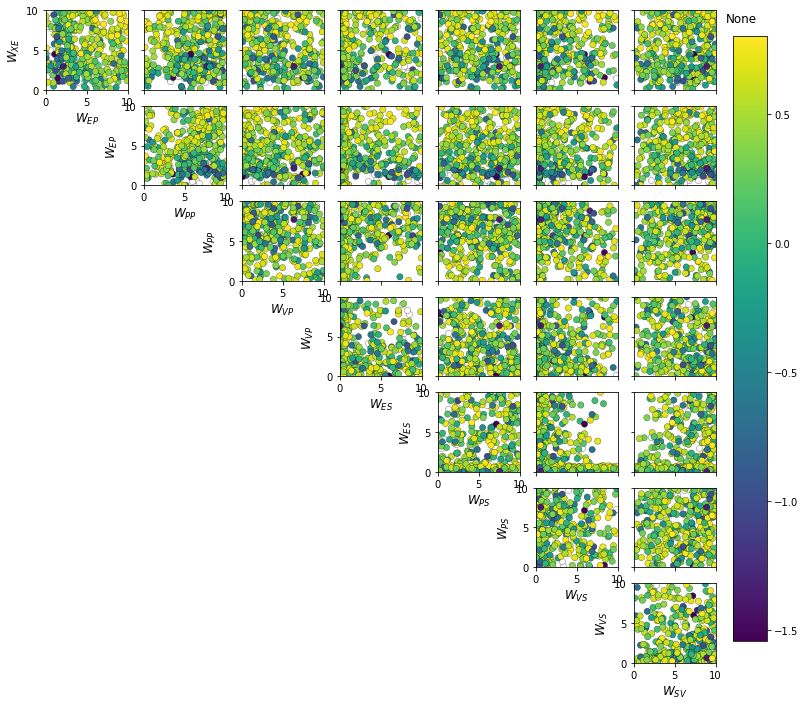

In [11]:
fig = pairplot(_Z[0,plot_inds], range(8), system.z_labels, 
               c=betas[plot_inds], xlims=[0, 10], ylims=[0, 10.0])

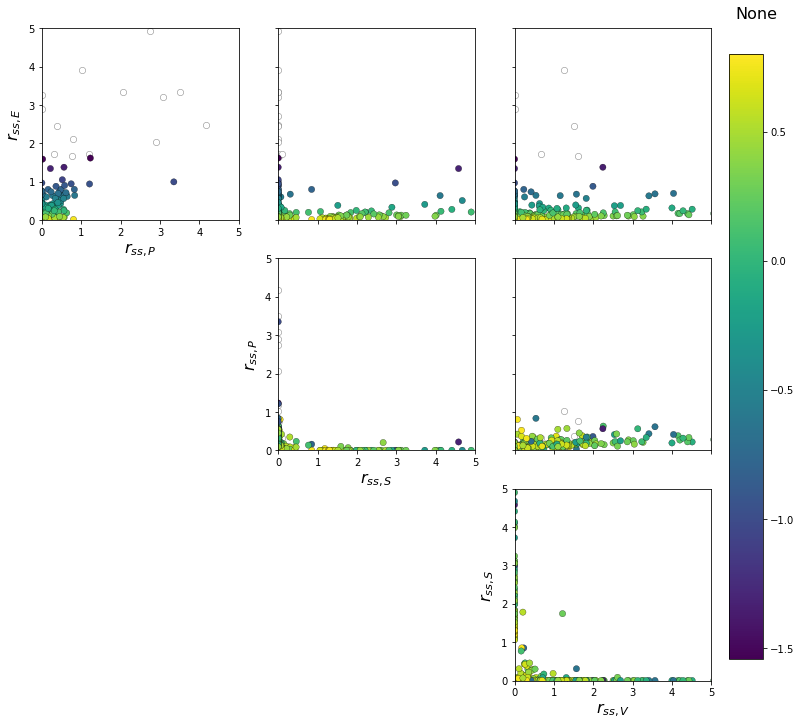

In [12]:
labels = [r'$r_{ss,E}$', r'$r_{ss,P}$', r'$r_{ss,S}$', r'$r_{ss,V}$']
fig = pairplot(r_ss[plot_inds], range(4), labels, c=betas[plot_inds], 
               fontsize=16, xlims=[0,5], ylims=[0,5])

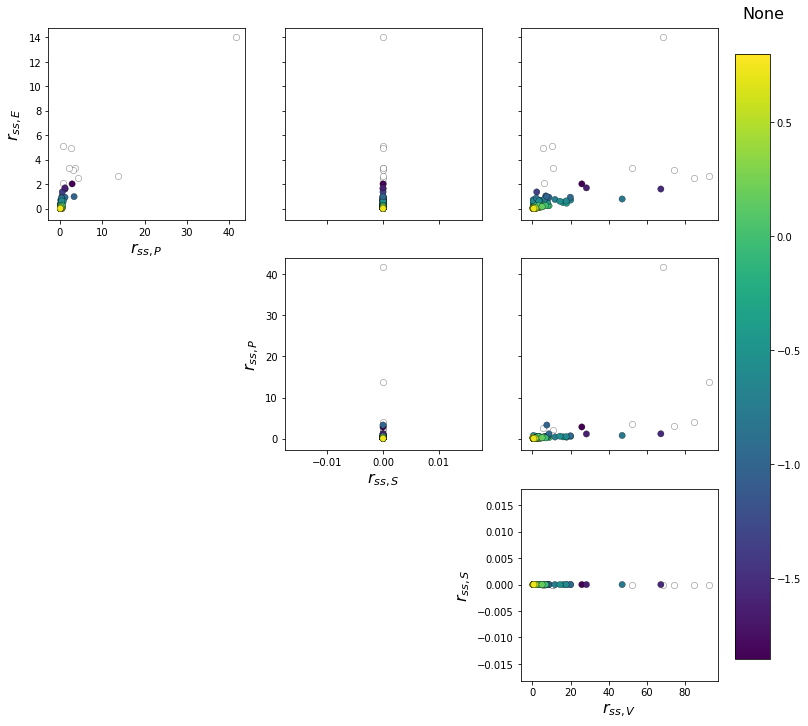

In [13]:
s_low = r_ss_S < 1e-3
plot2_inds = np.logical_and(s_low, plot_inds)
fig = pairplot(r_ss[plot2_inds], range(4), labels, c=betas[plot2_inds], 
               fontsize=16)

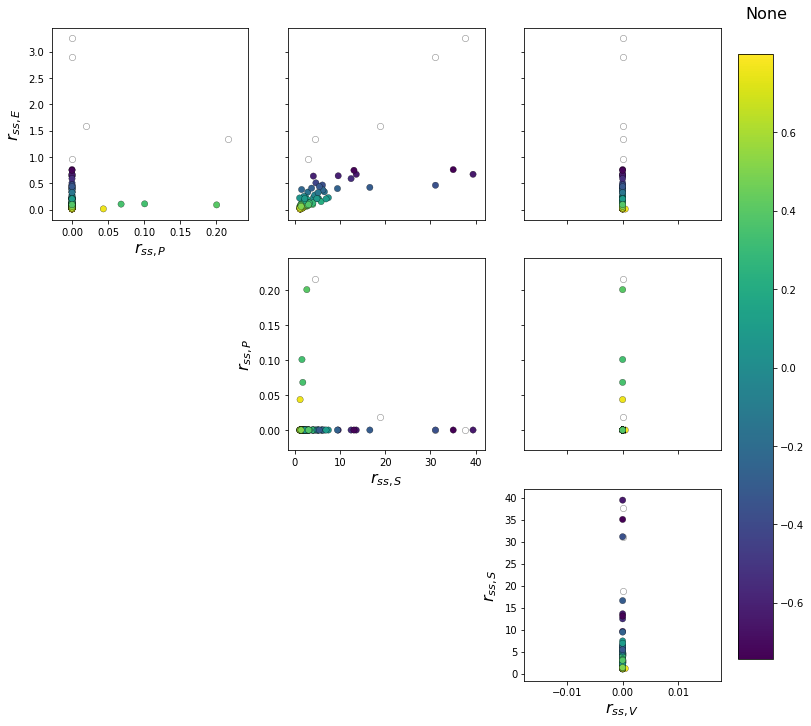

In [14]:
v_low = r_ss_V < 1e-3
plot3_inds = np.logical_and(v_low, plot_inds)
fig = pairplot(r_ss[plot3_inds], range(4), labels, c=betas[plot3_inds], 
               fontsize=16)

(array([   6.,   17.,    9.,   18.,   21.,   41.,   58.,   77.,   87.,
        1592.]),
 array([-0.99503267, -0.79553024, -0.59602782, -0.3965254 , -0.19702297,
         0.00247945,  0.20198188,  0.4014843 ,  0.60098673,  0.80048915,
         0.99999158]),
 <a list of 10 Patch objects>)

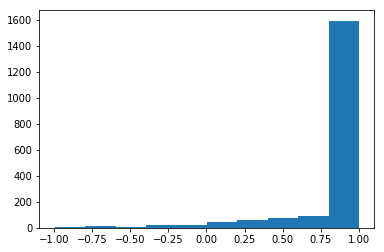

In [15]:
plt.hist(betas[betas > -1.0])

In [16]:
E_val = np.logical_and(0.3 < r_ss_E, r_ss_E < 0.6)
P_val = np.logical_and(0.3 < r_ss_P, r_ss_P < 0.6)
E_and_P_vals = np.logical_and(E_val, P_val)
print('# E %d, # P %d, # E&P %d' % (np.sum(E_val), np.sum(P_val), np.sum(E_and_P_vals)))

# E 33, # P 57, # E&P 6


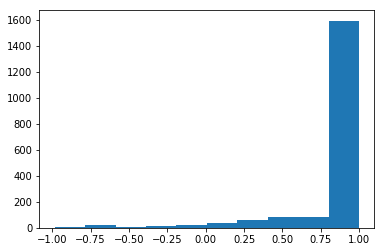

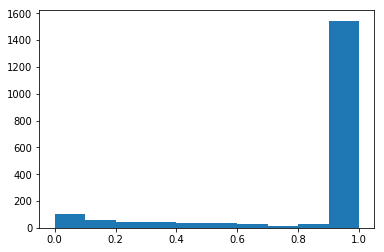

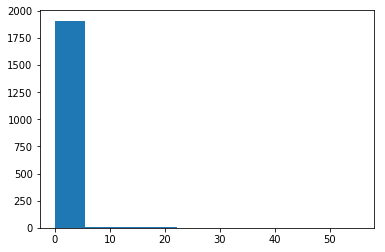

In [37]:
inds = _T_x[0,:,0] > -1
plt.figure()
plt.hist(_T_x[0,inds,0])
plt.show()

plt.figure()
plt.hist(_T_x[0,inds,1])
plt.show()

plt.figure()
plt.hist(_T_x[0,inds,2])
plt.show()

In [18]:
print(T_x.shape)

(1, ?, 2)
